<a href="https://colab.research.google.com/github/lyuly/cs224n/blob/main/exploring_word_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
# import sys.version_info[0]==3
# import sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.txt file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

!unzip /root/nltk_data/corpora/reuters.zip -d '/root/nltk_data/corpora/'

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
Archive:  /root/nltk_data/corpora/reuters.zip
replace /root/nltk_data/corpora/reuters/cats.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /root/nltk_data/corpora/reuters/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /root/nltk_data/corpora/reuters/stopwords? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /root/nltk_data/corpora/reuters/test/14826? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /root/nltk_data/corpora/reuters/test/14828? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /root/nltk_data/corpora/reuters/test/14829? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /root/nltk_data/corpora/reuters/test/14832? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /root/nltk_data/corpora/reuters/test/14833? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /root/nltk_data/corpora/reuters/test/14839? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Part1:基于计数的单词向量

In [3]:
# 从reuters中读取特定的种类
def read_corpus(category="grain"):
  files = reuters.fileids(category)
  return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [4]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'china', 'daily', 'says', 'vermin', 'eat', '7', '-', '12', 'pct', 'grain', 'stocks',
  'a', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume',
  'between', 'seven', 'and', '12', 'pct', 'of', 'china', "'", 's', 'grain', 'stocks', ',', 'the',
  'china', 'daily', 'said', '.', 'it', 'also', 'said', 'that', 'each', 'year', '1', '.', '575',
  'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'china', "'", 's', 'fruit', 'output', 'are',
  'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30',
  'pct', ',', 'of', 'its', 'vegetables', '.', 'the', 'paper', 'blamed', 'the', 'waste', 'on',
  'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'it', 'said', 'the',
  'government', 'had', 'launched', 'a', 'national', 'programme', 'to', 'reduce', 'waste', ',',
  'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', ',', 'and',
  'greater', 'production', 'of', 

In [5]:
# 找出语料库中不同的单词，列表返回的corpus_word应该是排过序的

def distinct_words(corpus):
  corpus_words = []
  n_corpus_words = -1

  corpus_words = sorted(set([x for lis in corpus for x in lis]))
  n_corpus_words = len(corpus_words)

  return corpus_words, n_corpus_words

In [6]:
# 运行检查

# 定义语料
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# 正确的答案
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# 测试正确的单词的数量
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# 测试正确的单词
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# 打印结果
print("-" * 80)
print("Passed All Tests!")
print("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [7]:
# 实现计算共现矩阵

def compute_co_occurrence_matrix(corpus, window_size=4):
  words, n_words = distinct_words(corpus)
  M = None
  word2ind = {}

  M = np.zeros((n_words, n_words))
  word2ind = {w: i for i, w in enumerate(words)}
  for doc in corpus:
    for i, word in enumerate(doc):
      for j in range(i-window_size, i + window_size + 1):
        if j < 0 or j >= len(doc):
          continue
        if j != i:
          M[word2ind[word], word2ind[doc[j]]] += 1

  return M, word2ind

In [8]:
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [9]:
# 实现减少到k维度
def reduce_to_k_dim(M, k=2):
  n_iters = 10
  M_reduced = None
  print("Running Truncated SVD over %i words..." % (M.shape[0]))

  SVD = TruncatedSVD(n_components=2, n_iter=n_iters)
  M_reduced = SVD.fit_transform(M)

  print("Done.")
  return M_reduced

In [10]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [11]:
#实现plot_embeddings

def plot_embeddings(M_reduced, word2ind, words):
  for word in words:
    coord = M_reduced[word2ind[word]]
    x = coord[0]
    y = coord[1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, word, fontsize=9)
  plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


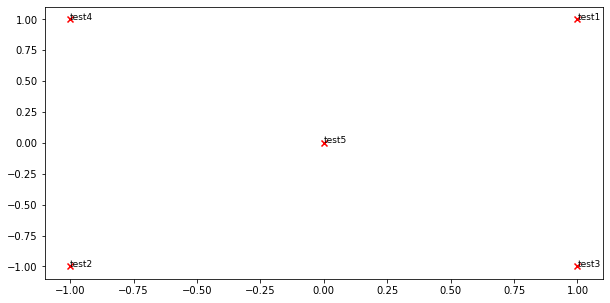

--------------------------------------------------------------------------------


In [12]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

Running Truncated SVD over 7146 words...
Done.


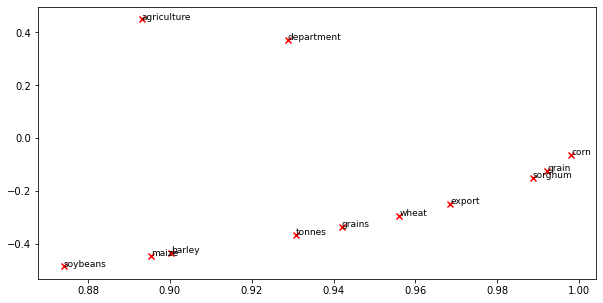

In [13]:
# 共现矩阵分析

reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#Part 2:基于预测的单词向量

In [14]:
!pip3 install --upgrade gensim

In [15]:
def load_embedding_model():
  import gensim.downloader as api
  wv_from_bin = api.load("glove-wiki-gigaword-200")
  print("Loaded vocab size is %i " % len(list(wv_from_bin.index_to_key)))
  return wv_from_bin

In [16]:
wv_from_bin = load_embedding_model()

Loaded vocab size is 400000 


In [17]:
# 减少word Embeddings的维度
def get_matrix_of_vectors(wv_from_bin, required_words=['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """

    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
      try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = curInd
        curInd += 1
      except KeyError:
        continue
    for w in required_words:
      if w in words:
        continue
      try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = curInd
        curInd += 1
      except KeyError:
        continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [18]:
# 减少200维度到k维度

M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis]

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


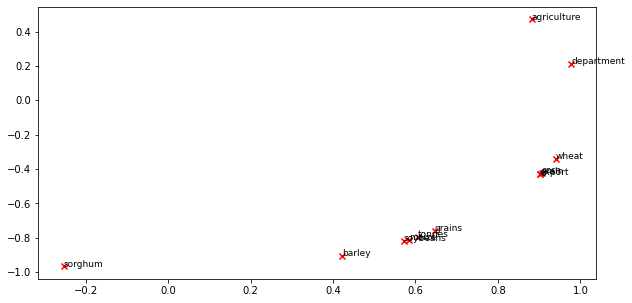

In [19]:
# Glove Plot Analysis
words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']
plot_embeddings(M_reduced_normalized, word2ind, words)

In [20]:
# words with Multiple Meanings
wv_from_bin.most_similar('cloud')

[('clouds', 0.7503163814544678),
 ('ash', 0.5862507820129395),
 ('shadow', 0.5425893068313599),
 ('dust', 0.531243085861206),
 ('sky', 0.5308398008346558),
 ('smoke', 0.5275063514709473),
 ('fog', 0.5158970355987549),
 ('horizon', 0.47844359278678894),
 ('mist', 0.4718891680240631),
 ('plume', 0.4643093943595886)]

In [25]:
wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]

In [26]:
wv_from_bin.most_similar('woman', 'man')

[('yesipova', 0.47934186458587646),
 ('scantily-clad', 0.46653106808662415),
 ('congresswoman', 0.4624992311000824),
 ('non-pregnant', 0.4618740379810333),
 ('arkhipova', 0.45348304510116577),
 ('menstruating', 0.444619357585907),
 ('premenopausal', 0.4388754665851593),
 ('bare-breasted', 0.4357142150402069),
 ('post-menopausal', 0.43187215924263),
 ('lactating', 0.42879149317741394)]

In [36]:
# 同义词和反义词
p1 = wv_from_bin.distance('happy','sad')
p2 = wv_from_bin.distance('happy', 'cheerful')
print("p1=", p1, "p2=", p2)

p1= 0.4040136933326721 p2= 0.5172466933727264


In [38]:
# positive和negative是反义词，它们的余弦距离是0.198577
# positive和energetic是近义词，它们的余弦距离是0.654664
q1 = wv_from_bin.distance('positive', 'negative')
q2 = wv_from_bin.distance('positive', 'energetic')
print("q1=", q1, "q2=", q2)

q1= 0.19857746362686157 q2= 0.6546646058559418


In [39]:
# 词向量的类比
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]


In [40]:
# 找到类比
pprint.pprint(wv_from_bin.most_similar(positive=['english', 'spain'], negative=['canada']))

[('spanish', 0.7254565358161926),
 ('portuguese', 0.5921587347984314),
 ('catalan', 0.555365800857544),
 ('madrid', 0.5476577877998352),
 ('castilian', 0.5269938111305237),
 ('barcelona', 0.5049525499343872),
 ('valencia', 0.4965393543243408),
 ('italian', 0.47707846760749817),
 ('arabic', 0.4736165404319763),
 ('andalusian', 0.46817514300346375)]


In [41]:
# 不正确的类比
pprint.pprint(wv_from_bin.most_similar(positive=['home', 'spain'], negative=['canada']))

[('madrid', 0.607631504535675),
 ('valencia', 0.5698319673538208),
 ('spanish', 0.5302673578262329),
 ('barcelona', 0.5268616080284119),
 ('mallorca', 0.5059105753898621),
 ('real', 0.5058016180992126),
 ('sevilla', 0.5054329633712769),
 ('villarreal', 0.4907064735889435),
 ('villa', 0.4902358949184418),
 ('betis', 0.48088976740837097)]


In [42]:
# 词向量偏差的引导分析
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'toy'], negative=['boy']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['boy', 'toy'], negative=['girl']))

[('toys', 0.7094953060150146),
 ('doll', 0.5932914614677429),
 ('dolls', 0.570662260055542),
 ('barbie', 0.5407706499099731),
 ('mattel', 0.5328551530838013),
 ('accessories', 0.5206909775733948),
 ('hasbro', 0.49227219820022583),
 ('jewelry', 0.47385692596435547),
 ('lego', 0.4690813422203064),
 ('apparel', 0.46136239171028137)]

[('toys', 0.71570885181427),
 ('hasbro', 0.5164632797241211),
 ('robot', 0.47317108511924744),
 ('pet', 0.4670490324497223),
 ('manufacturer', 0.4668163061141968),
 ('mattel', 0.4582391679286957),
 ('lego', 0.45811763405799866),
 ('miniature', 0.4441472291946411),
 ('makers', 0.44298243522644043),
 ('manufactured', 0.44275349378585815)]


In [43]:
# 另外一个例子
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'work'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'work'], negative=['woman']))

[('working', 0.7039693593978882),
 ('she', 0.6549049615859985),
 ('works', 0.6526206731796265),
 ('her', 0.62950599193573),
 ('worked', 0.6136812567710876),
 ('done', 0.5867578387260437),
 ('women', 0.5766420364379883),
 ('well', 0.5649346709251404),
 ('workers', 0.5586629509925842),
 ('job', 0.5585523247718811)]

[('working', 0.6912841796875),
 ('done', 0.6648033857345581),
 ('works', 0.6581295132637024),
 ('well', 0.653425931930542),
 ('way', 0.630937397480011),
 ('worked', 0.6259487271308899),
 ('so', 0.6176828145980835),
 ('he', 0.614930272102356),
 ('but', 0.6092712879180908),
 ('how', 0.606387734413147)]
